# Mlb Player_info

## imports 

In [132]:
import pandas as pd
import numpy as np
import sqlite3
from datetime import timedelta
import os
from imblearn.over_sampling import SMOTE 
%pip install imbalanced-learn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE 


[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [3]:
db_path = '/Users/daniellarson/Desktop/Code/Projects/dodgers_injtrkr/mlb/mlb_players.db'
conn = sqlite3.connect(db_path)
cursor = conn.cursor()

# Set up your DB path
base_dir = '/Users/daniellarson/Desktop/Code/Projects/dodgers_injtrkr'
db_path = os.path.join(base_dir, 'data', 'mlb_players.db')  
pd.set_option('display.max_columns', None)

In [4]:
tables = pd.read_sql_query("SELECT name FROM sqlite_master WHERE type='table';", conn) 
print(tables) 

               name
0   mlb_player_info
1   sqlite_sequence
2      injury_stats
3  mlb_player_stats


## MLB Player info 

In [12]:
mlb_player_info = pd.read_sql_query("SELECT * FROM mlb_player_info", conn)

mlb_player_info.head()


,id,mlb_player_id,fullName,firstName,lastName,birthDate,currentAge,birthCity,birthStateProvince,birthCountry,height,weight,primaryPosition,batSide,pitchHand,debutDate,active
0,1,671096,Andrew Abbott,Andrew,Abbott,1999-06-01,25,Lynchburg,VA,USA,"6' 0""",192,Pitcher,Left,Left,2023-06-05,1
1,2,682928,CJ Abrams,Paul,Abrams,2000-10-03,24,Alpharetta,GA,USA,"6' 0""",191,Shortstop,Left,Right,2022-04-08,1
2,3,650556,Bryan Abreu,Bryan,Abreu,1997-04-22,28,Santo Domingo Centro,None,Dominican Republic,"6' 1""",230,Pitcher,Right,Right,2019-07-31,1
3,4,677800,Wilyer Abreu,Wilyer,Abreu,1999-06-24,25,Maracaibo,None,Venezuela,"5' 10""",215,Outfielder,Left,Left,2023-08-22,1
4,5,682668,Luisangel Acuña,Luisangel,Acuña,2002-03-12,23,Caracas,None,Venezuela,"5' 8""",181,Second Base,Right,Right,2024-09-14,1


In [ ]:

# Get the last 10 mlb_player_ids

query = """
SELECT mlb_player_id
FROM mlb_player_info
ORDER BY mlb_player_id DESC
LIMIT 10;
"""

pd.read_sql_query(query, conn)

,mlb_player_id
0,820862
1,810938
2,808982
3,808975
4,808967
5,808963
6,807713
7,807712
8,806188
9,806185


## MLB Player stats 

In [72]:
mlb_player_stats = pd.read_sql_query("SELECT * FROM mlb_player_stats", conn)

mlb_player_stats

,mlb_player_id,stat_type,stat_group,season,game_date,team_id,team_name,opponent_id,opponent_name,position,gamesPlayed,games,gamesStarted,assists,putOuts,errors,chances,fielding,doublePlays,triplePlays,throwingErrors,rangeFactorPerGame,rangeFactorPer9Inn,innings,inningsPitched,catcherERA,flyOuts,groundOuts,airOuts,passedBall,wins,losses,wildPitches,pickoffs,runs,doubles,triples,homeRuns,strikeOuts,baseOnBalls,intentionalWalks,hits,hitByPitch,avg,atBats,obp,slg,ops,caughtStealing,stolenBases,stolenBasePercentage,groundIntoDoublePlay,groundIntoTriplePlay,numberOfPitches,plateAppearances,totalBases,rbi,leftOnBase,sacBunts,sacFlies,babip,groundOutsToAirouts,catchersInterference,atBatsPerHomeRun,summary,isHome,isWin,game_id,game_number,day_night,era,game
0,445276,season,fielding,2024,None,111.0,Boston Red Sox,NaN,None,NA,54,54,0.0,1.0,1.0,0.0,2.0,1.000,0.0,0.0,0.0,0.04,0.33,54.2,None,None,NaN,NaN,NaN,NaN,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,None,None,None,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None,NaN,None,None,NaN,NaN,NaN,NaN,None,na,na
1,445276,season,hitting,2024,None,111.0,Boston Red Sox,NaN,None,None,54,na,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN,None,None,None,None,None,NaN,0.0,0.0,NaN,None,None,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,.000,0.0,.000,.000,.000,0.0,0.0,.---,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,.---,-.--,0.0,-.--,None,NaN,NaN,NaN,NaN,None,na,na
2,455117,season,fielding,2024,None,145.0,Chicago White Sox,NaN,None,NA,48,48,46.0,11.0,378.0,2.0,391.0,.995,0.0,0.0,1.0,8.10,9.02,388.2,None,4.61,NaN,NaN,NaN,3.0,None,None,18.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,None,None,None,3.0,39.0,.929,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None,1.0,None,None,NaN,NaN,NaN,NaN,None,na,na
3,455117,season,hitting,2024,None,145.0,Chicago White Sox,NaN,None,None,48,na,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN,None,None,None,None,None,NaN,30.0,41.0,NaN,None,None,NaN,NaN,9.0,3.0,0.0,4.0,51.0,8.0,0.0,16.0,1.0,.119,135.0,.174,.230,.404,0.0,0.0,.---,5.0,NaN,556.0,147.0,31.0,11.0,56.0,3.0,0.0,.150,0.73,0.0,33.75,None,NaN,NaN,NaN,NaN,None,na,na
4,455117,career,fielding,None,None,NaN,None,NaN,None,NA,1132,1132,1053.0,513.0,9044.0,63.0,9620.0,.993,47.0,0.0,51.0,8.44,9.32,9227.1,None,3.81,NaN,NaN,NaN,78.0,None,None,367.0,22.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,None,None,None,184.0,444.0,.707,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None,16.0,None,None,NaN,NaN,NaN,NaN,None,na,na
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
436883,810938,gameLog,fielding,2025,2025-05-13,136.0,Seattle Mariners,147.0,New York Yankees,NA,1,1,1.0,3.0,0.0,0.0,3.0,.964,0.0,0.0,0.0,3.00,2.45,11.0,None,None,NaN,NaN,NaN,NaN,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,None,None,None,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None,NaN,None,None,1.0,1.0,777926.0,1.0,day,na,na
436884,810938,gameLog,fielding,2025,2025-05-14,136.0,Seattle Mariners,147.0,New York Yankees,NA,1,1,1.0,2.0,1.0,0.0,3.0,.966,0.0,0.0,0.0,3.00,3.00,9.0,None,None,NaN,NaN,NaN,NaN,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,None,None,None,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None,NaN,None,None,1.0,0.0,777915.0,1.0,day,na,na
436885,810938,gameLog,fielding,2025,2025-05-16,136.0,Seattle Mariners,135.0,San Diego Padres,NA,1,1,1.0,2.0,0.0,0.0,2.0,.967,0.0,0.0,0.0,2.00,2.00,9.0,None,None,NaN,NaN,NaN,NaN,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,None,None,None,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None,NaN,None,None,0.0,1.0,777896.0,1.0,day,na,na
436886,810938,gameLog,fielding,2025,2025-05-17,136.0,Seattle Mariners,135.0,San Diego Padres,NA,1,1,1.0,1.0,0.0,0.0,1.0,.968,0.0,0.0,0.0,1.00,1.00,9.0,None,None,NaN,NaN,NaN

In [71]:
mlb_player_stats.columns

Index(['mlb_player_id', 'stat_type', 'stat_group', 'season', 'game_date',
       'team_id', 'team_name', 'opponent_id', 'opponent_name', 'position',
       'gamesPlayed', 'games', 'gamesStarted', 'assists', 'putOuts', 'errors',
       'chances', 'fielding', 'doublePlays', 'triplePlays', 'throwingErrors',
       'rangeFactorPerGame', 'rangeFactorPer9Inn', 'innings', 'inningsPitched',
       'catcherERA', 'flyOuts', 'groundOuts', 'airOuts', 'passedBall', 'wins',
       'losses', 'wildPitches', 'pickoffs', 'runs', 'doubles', 'triples',
       'homeRuns', 'strikeOuts', 'baseOnBalls', 'intentionalWalks', 'hits',
       'hitByPitch', 'avg', 'atBats', 'obp', 'slg', 'ops', 'caughtStealing',
       'stolenBases', 'stolenBasePercentage', 'groundIntoDoublePlay',
       'groundIntoTriplePlay', 'numberOfPitches', 'plateAppearances',
       'totalBases', 'rbi', 'leftOnBase', 'sacBunts', 'sacFlies', 'babip',
       'groundOutsToAirouts', 'catchersInterference', 'atBatsPerHomeRun',
       'summary', '

In [ ]:
# Ecample csv of mlb_player_stats

mlb_player_stats_example = mlb_player_stats.head(100)

#mlb_player_stats_example.to_csv('mlb_player_stats_example.csv', index=False)

## Player info and stats

In [ ]:
query = """
SELECT mlb_player_stats.* , mlb_player_info.*
FROM mlb_player_stats
JOIN mlb_player_info ON mlb_player_stats.mlb_player_id = mlb_player_info.mlb_player_id
"""
player_pre = pd.read_sql_query(query, conn)

# Reorder columns: fullName and mlb_player_id first, then the rest
cols = ['fullName', 'mlb_player_id'] + [col for col in player_pre.columns if col not in ['fullName', 'mlb_player_id']]
player_pre = player_pre[cols]

# Rename columns to make them more readable
player_df = player_pre.rename(columns={
    'fullName': 'Name',
    'mlb_player_id': 'PlayerID',
    'stat_type': 'StatType',
    'stat_group': 'StatGroup',
    'season': 'Season',
    'game_date': 'GameDate',
    'team_id': 'TeamID',
    'team_name': 'Team',
    'opponent_id': 'OpponentID',
    'opponent_name': 'Opponent',
    'position': 'Position',
    'gamesPlayed': 'GamesPlayed',
    'games': 'Games',
    'gamesStarted': 'GamesStarted',
    'assists': 'Assists',
    'putOuts': 'PutOuts',
    'errors': 'Errors',
    'chances': 'Chances',
    'fielding': 'Fielding%',
    'doublePlays': 'DoublePlays',
    'triplePlays': 'TriplePlays',
    'throwingErrors': 'ThrowingErrors',
    'rangeFactorPerGame': 'RangeFactor/Game',
    'rangeFactorPer9Inn': 'RangeFactor/9Inn',
    'innings': 'Innings',
    'inningsPitched': 'InningsPitched',
    'catcherERA': 'CatcherERA',
    'flyOuts': 'FlyOuts',
    'groundOuts': 'GroundOuts',
    'airOuts': 'AirOuts',
    'passedBall': 'PassedBall',
    'wins': 'Wins',
    'losses': 'Losses',
    'wildPitches': 'WildPitches',
    'pickoffs': 'Pickoffs',
    'runs': 'Runs',
    'doubles': 'Doubles',
    'triples': 'Triples',
    'homeRuns': 'HomeRuns',
    'strikeOuts': 'Strikeouts',
    'baseOnBalls': 'Walks',
    'intentionalWalks': 'IntentionalWalks',
    'hits': 'Hits',
    'hitByPitch': 'HitByPitch',
    'avg': 'BattingAvg',
    'atBats': 'AtBats',
    'obp': 'OnBase%',
    'slg': 'Slugging%',
    'ops': 'OPS',
    'caughtStealing': 'CaughtStealing',
    'stolenBases': 'StolenBases',
    'stolenBasePercentage': 'Steal%',
    'groundIntoDoublePlay': 'GIDP',
    'groundIntoTriplePlay': 'GITP',
    'numberOfPitches': 'PitchesThrown',
    'plateAppearances': 'PlateAppearances',
    'totalBases': 'TotalBases',
    'rbi': 'RBIs',
    'leftOnBase': 'LOB',
    'sacBunts': 'SacBunts',
    'sacFlies': 'SacFlies',
    'babip': 'BABIP',
    'groundOutsToAirouts': 'GO/AO',
    'catchersInterference': 'CatchersInterference',
    'atBatsPerHomeRun': 'AB/HR',
    'summary': 'Summary',
    'isHome': 'HomeGame',
    'isWin': 'Win',
    'game_id': 'GameID',
    'game_number': 'GameNumber',
    'day_night': 'GameTime',
    'era': 'ERA',
    'game': 'Game',
    'id': 'RowID',
    'firstName': 'FirstName',
    'lastName': 'LastName',
    'birthDate': 'BirthDate',
    'currentAge': 'Age',
    'birthCity': 'BirthCity',
    'birthStateProvince': 'BirthState',
    'birthCountry': 'BirthCountry',
    'height': 'Height',
    'weight': 'Weight',
    'primaryPosition': 'PrimaryPosition',
    'batSide': 'BatSide',
    'pitchHand': 'PitchHand',
    'debutDate': 'DebutDate',
    'active': 'IsActive'
})

# Show the updated DataFrame
player_pre.columns

Index(['fullName', 'mlb_player_id', 'mlb_player_id', 'stat_type', 'stat_group',
       'season', 'game_date', 'team_id', 'team_name', 'opponent_id',
       'opponent_name', 'position', 'gamesPlayed', 'games', 'gamesStarted',
       'assists', 'putOuts', 'errors', 'chances', 'fielding', 'doublePlays',
       'triplePlays', 'throwingErrors', 'rangeFactorPerGame',
       'rangeFactorPer9Inn', 'innings', 'inningsPitched', 'catcherERA',
       'flyOuts', 'groundOuts', 'airOuts', 'passedBall', 'wins', 'losses',
       'wildPitches', 'pickoffs', 'runs', 'doubles', 'triples', 'homeRuns',
       'strikeOuts', 'baseOnBalls', 'intentionalWalks', 'hits', 'hitByPitch',
       'avg', 'atBats', 'obp', 'slg', 'ops', 'caughtStealing', 'stolenBases',
       'stolenBasePercentage', 'groundIntoDoublePlay', 'groundIntoTriplePlay',
       'numberOfPitches', 'plateAppearances', 'totalBases', 'rbi',
       'leftOnBase', 'sacBunts', 'sacFlies', 'babip', 'groundOutsToAirouts',
       'catchersInterference', 'at

In [ ]:
player_df.columns

player_stats = player_df

#player_stats.to_csv('player_stats.csv', index=False)

In [37]:
player_stats.head(10)
player_stats.columns

Index(['Name', 'PlayerID', 'PlayerID', 'StatType', 'StatGroup', 'Season',
       'GameDate', 'TeamID', 'Team', 'OpponentID', 'Opponent', 'Position',
       'GamesPlayed', 'Games', 'GamesStarted', 'Assists', 'PutOuts', 'Errors',
       'Chances', 'Fielding%', 'DoublePlays', 'TriplePlays', 'ThrowingErrors',
       'RangeFactor/Game', 'RangeFactor/9Inn', 'Innings', 'InningsPitched',
       'CatcherERA', 'FlyOuts', 'GroundOuts', 'AirOuts', 'PassedBall', 'Wins',
       'Losses', 'WildPitches', 'Pickoffs', 'Runs', 'Doubles', 'Triples',
       'HomeRuns', 'Strikeouts', 'Walks', 'IntentionalWalks', 'Hits',
       'HitByPitch', 'BattingAvg', 'AtBats', 'OnBase%', 'Slugging%', 'OPS',
       'CaughtStealing', 'StolenBases', 'Steal%', 'GIDP', 'GITP',
       'PitchesThrown', 'PlateAppearances', 'TotalBases', 'RBIs', 'LOB',
       'SacBunts', 'SacFlies', 'BABIP', 'GO/AO', 'CatchersInterference',
       'AB/HR', 'Summary', 'HomeGame', 'Win', 'GameID', 'GameNumber',
       'GameTime', 'ERA', 'Game', 'R

In [ ]:

# Save the DataFrame to a CSV file
#player_stats.to_csv('mlb_stats.csv', index=False)

## Injury Stats 

In [105]:
injury_stats = pd.read_sql_query("SELECT * FROM injury_stats", conn)

In [70]:
injury_stats.columns

Index(['mlb_player_id', 'player_name', 'injury_date', 'season',
       'injury_description', 'team_name'],
      dtype='object')

In [20]:
injury_stats

,mlb_player_id,player_name,injury_date,season,injury_description,team_name
0,434378,Justin Verlander,2015-04-08,2015,Detroit Tigers placed RHP Justin Verlander on ...,Detroit Tigers
1,434378,Justin Verlander,2015-06-13,2015,Detroit Tigers activated RHP Justin Verlander ...,Detroit Tigers
2,434378,Justin Verlander,2020-07-27,2020,Houston Astros placed RHP Justin Verlander on ...,Houston Astros
3,434378,Justin Verlander,2020-09-28,2020,Houston Astros activated RHP Justin Verlander ...,Houston Astros
4,434378,Justin Verlander,2021-02-27,2021,Houston Astros placed P Justin Verlander on th...,Houston Astros
...,...,...,...,...,...,...
8608,808982,Jung Hoo Lee,2024-05-13,2024,San Francisco Giants placed OF Jung Hoo Lee on...,San Francisco Giants
8609,808982,Jung Hoo Lee,2024-05-18,2024,San Francisco Giants transferred OF Jung Hoo L...,San Francisco Giants
8610,808982,Jung Hoo Lee,2024-11-04,2024,San Francisco Giants activated CF Jung Hoo Lee...,San Francisco Giants
8611,810938,Ben Williamson,2023-08-23,2023,Modesto Nuts placed 3B Ben Williamson on the 7...,Modesto Nuts


In [15]:
injury_stats_exmple = injury_stats.head(100)

injury_stats_exmple.to_csv('injury_stats_example.csv', index=False)

In [ ]:

# Save injury_stats to CSV

#injury_stats.to_csv('injury_stats.csv', index=False)

## Injury Stats and Player Data 

In [102]:

# Load both tables using the existing connection
injuries = pd.read_sql_query("SELECT * FROM injury_stats", conn)
stats = pd.read_sql_query("SELECT * FROM mlb_player_stats", conn)

# Convert to datetime
injuries['injury_date'] = pd.to_datetime(injuries['injury_date'], errors='coerce')
stats['game_date'] = pd.to_datetime(stats['game_date'], errors='coerce')
stats = stats.dropna(subset=['game_date'])

# Only keep meaningful stat rows (optional)
stats = stats[stats['stat_type'].str.lower().str.contains('gamelog|hitting|pitching', na=False)]

# Build merged DataFrame
rows = []
for _, injury in injuries.iterrows():
    player_id = injury['mlb_player_id']
    injury_date = injury['injury_date']

    window_df = stats[
        (stats['mlb_player_id'] == player_id) &
        (stats['game_date'] >= injury_date - timedelta(days=10)) &
        (stats['game_date'] <= injury_date)
    ].copy()

    if not window_df.empty:
        window_df['injury_date'] = injury_date
        window_df['injury_description'] = injury['injury_description']
        rows.append(window_df)

# Final merged table
injury_player_stats = pd.concat(rows, ignore_index=True)
injury_player_stats = injury_player_stats.rename(columns={
    'mlb_player_id': 'PlayerID',
    'game_date': 'GameDate',
    'stat_type': 'StatType',
    'stat_group': 'StatGroup',
    'team_id': 'TeamID',
    'team_name': 'Team',
    'opponent_id': 'OpponentID',
    'opponent_name': 'Opponent',
    'position': 'Position',
    'gamesPlayed': 'GamesPlayed',
    'games': 'Games',
    'gamesStarted': 'GamesStarted',
    # Add other renaming as needed
})

#injury_player_stats.to_csv("injury_player_stats.csv", index=False)
#print("✅ Merged injury window saved to data/injury_merged_window.csv")

In [103]:
injury_player_stats 

,PlayerID,StatType,StatGroup,season,GameDate,TeamID,Team,OpponentID,Opponent,Position,GamesPlayed,Games,GamesStarted,assists,putOuts,errors,chances,fielding,doublePlays,triplePlays,throwingErrors,rangeFactorPerGame,rangeFactorPer9Inn,innings,inningsPitched,catcherERA,flyOuts,groundOuts,airOuts,passedBall,wins,losses,wildPitches,pickoffs,runs,doubles,triples,homeRuns,strikeOuts,baseOnBalls,intentionalWalks,hits,hitByPitch,avg,atBats,obp,slg,ops,caughtStealing,stolenBases,stolenBasePercentage,groundIntoDoublePlay,groundIntoTriplePlay,numberOfPitches,plateAppearances,totalBases,rbi,leftOnBase,sacBunts,sacFlies,babip,groundOutsToAirouts,catchersInterference,atBatsPerHomeRun,summary,isHome,isWin,game_id,game_number,day_night,era,game,injury_date,injury_description
0,456781,gameLog,fielding,2021,2021-04-12,137.0,San Francisco Giants,113.0,Cincinnati Reds,NA,1,1,1.0,2.0,1.0,0.0,3.0,1.000,0.0,0.0,0.0,3.00,3.00,9.0,None,None,NaN,NaN,NaN,NaN,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,None,None,None,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None,NaN,None,None,1.0,0.0,634648.0,1.0,day,na,na,2021-04-22,San Francisco Giants placed 2B Donovan Solano ...
1,456781,gameLog,fielding,2021,2021-04-13,137.0,San Francisco Giants,113.0,Cincinnati Reds,NA,1,1,0.0,0.0,1.0,0.0,1.0,1.000,0.0,0.0,0.0,1.00,4.50,2.0,None,None,NaN,NaN,NaN,NaN,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,None,None,None,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None,NaN,None,None,1.0,1.0,634510.0,1.0,day,na,na,2021-04-22,San Francisco Giants placed 2B Donovan Solano ...
2,456781,gameLog,fielding,2021,2021-04-14,137.0,San Francisco Giants,113.0,Cincinnati Reds,NA,1,1,1.0,3.0,2.0,0.0,5.0,1.000,1.0,0.0,0.0,5.00,5.00,9.0,None,None,NaN,NaN,NaN,NaN,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,None,None,None,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None,NaN,None,None,1.0,1.0,634582.0,1.0,day,na,na,2021-04-22,San Francisco Giants placed 2B Donovan Solano ...
3,456781,gameLog,fielding,2021,2021-04-16,137.0,San Francisco Giants,146.0,Miami Marlins,NA,1,1,1.0,2.0,1.0,0.0,3.0,1.000,0.0,0.0,0.0,3.00,3.38,8.0,None,None,NaN,NaN,NaN,NaN,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,None,None,None,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None,NaN,None,None,0.0,0.0,634519.0,1.0,day,na,na,2021-04-22,San Francisco Giants placed 2B Donovan Solano ...
4,456781,gameLog,fielding,2021,2021-04-17,137.0,San Francisco Giants,146.0,Miami Marlins,NA,1,1,0.0,1.0,0.0,0.0,1.0,1.000,0.0,0.0,0.0,1.00,3.00,3.2,None,None,NaN,NaN,NaN,NaN,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,None,None,None,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None,NaN,None,None,0.0,0.0,634450.0,1.0,day,na,na,2021-04-22,San Francisco Giants placed 2B Donovan Solano ...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15259,808982,gameLog,hitting,2024,2024-05-12,137.0,San Francisco Giants,113.0,Cincinnati Reds,None,1,na,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN,None,None,None,None,None,0.0,0.0,0.0,NaN,None,None,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,.262,0.0,.310,.331,.641,0.0,0.0,.---,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,.---,-.--,0.0,-.--,0-0,1.0,1.0,745345.0,1.0,day,na,na,2024-05-18,San Francisco Giants transferred OF Jung Hoo L...
15260,808982,gameLog,hitting,2024,2024-05-08,137.0,San Francisco Giants,115.0,Colorado Rockies,None,1,na,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN,None,None,None,None,None,3.0,1.0,3.0,NaN,None,None,NaN,NaN,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,.262,5.0,.310,.331,.641,0.0,0.0,.---,0.0,0.0,19.0,5.0,2.0,1.0,2.0,0.0,0.0,.200,0.33,0.0,-.--,"1-5 | 2B, RBI, R",0.0,1.0,746562.0,1.0,day,na,na,2024-05-18,San Francisco Giants tra

## The Dodgers Stats

In [27]:
# Step 1: SQL query to join stats and info for all players
query = """
SELECT mlb_player_stats.*, mlb_player_info.*
FROM mlb_player_stats
JOIN mlb_player_info ON mlb_player_stats.mlb_player_id = mlb_player_info.mlb_player_id
WHERE mlb_player_stats.team_name = 'Los Angeles Dodgers' AND Season = 2025
;
"""

# Step 2: Load the result into a pandas DataFrame
dodgers_player_pre = pd.read_sql_query(query, conn)

# Step 4: Rename columns for readability
dodgers_df = dodgers_player_pre.rename(columns={
    'fullName': 'Name',
    'mlb_player_id': 'PlayerID',
    'stat_type': 'StatType',
    'stat_group': 'StatGroup',
    'season': 'Season',
    'game_date': 'GameDate',
    'team_id': 'TeamID',
    'team_name': 'Team',
    'opponent_id': 'OpponentID',
    'opponent_name': 'Opponent',
    'position': 'Position',
    'gamesPlayed': 'GamesPlayed',
    'games': 'Games',
    'gamesStarted': 'GamesStarted',
    'assists': 'Assists',
    'putOuts': 'PutOuts',
    'errors': 'Errors',
    'chances': 'Chances',
    'fielding': 'Fielding%',
    'doublePlays': 'DoublePlays',
    'triplePlays': 'TriplePlays',
    'throwingErrors': 'ThrowingErrors',
    'rangeFactorPerGame': 'RangeFactor/Game',
    'rangeFactorPer9Inn': 'RangeFactor/9Inn',
    'innings': 'Innings',
    'inningsPitched': 'InningsPitched',
    'catcherERA': 'CatcherERA',
    'flyOuts': 'FlyOuts',
    'groundOuts': 'GroundOuts',
    'airOuts': 'AirOuts',
    'passedBall': 'PassedBall',
    'wins': 'Wins',
    'losses': 'Losses',
    'wildPitches': 'WildPitches',
    'pickoffs': 'Pickoffs',
    'runs': 'Runs',
    'doubles': 'Doubles',
    'triples': 'Triples',
    'homeRuns': 'HomeRuns',
    'strikeOuts': 'Strikeouts',
    'baseOnBalls': 'Walks',
    'intentionalWalks': 'IntentionalWalks',
    'hits': 'Hits',
    'hitByPitch': 'HitByPitch',
    'avg': 'BattingAvg',
    'atBats': 'AtBats',
    'obp': 'OnBase%',
    'slg': 'Slugging%',
    'ops': 'OPS',
    'caughtStealing': 'CaughtStealing',
    'stolenBases': 'StolenBases',
    'stolenBasePercentage': 'Steal%',
    'groundIntoDoublePlay': 'GIDP',
    'groundIntoTriplePlay': 'GITP',
    'numberOfPitches': 'PitchesThrown',
    'plateAppearances': 'PlateAppearances',
    'totalBases': 'TotalBases',
    'rbi': 'RBIs',
    'leftOnBase': 'LOB',
    'sacBunts': 'SacBunts',
    'sacFlies': 'SacFlies',
    'babip': 'BABIP',
    'groundOutsToAirouts': 'GO/AO',
    'catchersInterference': 'CatchersInterference',
    'atBatsPerHomeRun': 'AB/HR',
    'summary': 'Summary',
    'isHome': 'HomeGame',
    'isWin': 'Win',
    'game_id': 'GameID',
    'game_number': 'GameNumber',
    'day_night': 'GameTime',
    'era': 'ERA',
    'game': 'Game',
    'id': 'RowID',
    'firstName': 'FirstName',
    'lastName': 'LastName',
    'birthDate': 'BirthDate',
    'currentAge': 'Age',
    'birthCity': 'BirthCity',
    'birthStateProvince': 'BirthState',
    'birthCountry': 'BirthCountry',
    'height': 'Height',
    'weight': 'Weight',
    'primaryPosition': 'PrimaryPosition',
    'batSide': 'BatSide',
    'pitchHand': 'PitchHand',
    'debutDate': 'DebutDate',
    'active': 'IsActive'
})



In [29]:
dodgers_df.columns

Index(['PlayerID', 'StatType', 'StatGroup', 'Season', 'GameDate', 'TeamID',
       'Team', 'OpponentID', 'Opponent', 'Position', 'GamesPlayed', 'Games',
       'GamesStarted', 'Assists', 'PutOuts', 'Errors', 'Chances', 'Fielding%',
       'DoublePlays', 'TriplePlays', 'ThrowingErrors', 'RangeFactor/Game',
       'RangeFactor/9Inn', 'Innings', 'InningsPitched', 'CatcherERA',
       'FlyOuts', 'GroundOuts', 'AirOuts', 'PassedBall', 'Wins', 'Losses',
       'WildPitches', 'Pickoffs', 'Runs', 'Doubles', 'Triples', 'HomeRuns',
       'Strikeouts', 'Walks', 'IntentionalWalks', 'Hits', 'HitByPitch',
       'BattingAvg', 'AtBats', 'OnBase%', 'Slugging%', 'OPS', 'CaughtStealing',
       'StolenBases', 'Steal%', 'GIDP', 'GITP', 'PitchesThrown',
       'PlateAppearances', 'TotalBases', 'RBIs', 'LOB', 'SacBunts', 'SacFlies',
       'BABIP', 'GO/AO', 'CatchersInterference', 'AB/HR', 'Summary',
       'HomeGame', 'Win', 'GameID', 'GameNumber', 'GameTime', 'ERA', 'Game',
       'RowID', 'PlayerID', '

In [28]:
dodgers_df

,PlayerID,StatType,StatGroup,Season,GameDate,TeamID,Team,OpponentID,Opponent,Position,GamesPlayed,Games,GamesStarted,Assists,PutOuts,Errors,Chances,Fielding%,DoublePlays,TriplePlays,ThrowingErrors,RangeFactor/Game,RangeFactor/9Inn,Innings,InningsPitched,CatcherERA,FlyOuts,GroundOuts,AirOuts,PassedBall,Wins,Losses,WildPitches,Pickoffs,Runs,Doubles,Triples,HomeRuns,Strikeouts,Walks,IntentionalWalks,Hits,HitByPitch,BattingAvg,AtBats,OnBase%,Slugging%,OPS,CaughtStealing,StolenBases,Steal%,GIDP,GITP,PitchesThrown,PlateAppearances,TotalBases,RBIs,LOB,SacBunts,SacFlies,BABIP,GO/AO,CatchersInterference,AB/HR,Summary,HomeGame,Win,GameID,GameNumber,GameTime,ERA,Game,RowID,PlayerID,Name,FirstName,LastName,BirthDate,Age,BirthCity,BirthState,BirthCountry,Height,Weight,PrimaryPosition,BatSide,PitchHand,DebutDate,IsActive
0,489446,season,fielding,2025,None,119,Los Angeles Dodgers,NaN,None,NA,22,22,0.0,3.0,2.0,0.0,5.0,1.000,0.0,0.0,0.0,0.23,2.50,18.2,None,None,NaN,NaN,NaN,NaN,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,None,None,None,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None,NaN,None,None,NaN,NaN,NaN,NaN,None,na,na,1087,489446,Kirby Yates,Kirby,Yates,1987-03-25,38,Lihue,HI,USA,"5' 10""",205,Pitcher,Left,Right,2014-06-07,1
1,518692,season,hitting,2025,None,119,Los Angeles Dodgers,NaN,None,None,37,na,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN,None,None,None,None,None,NaN,25.0,35.0,NaN,None,None,NaN,NaN,27.0,11.0,1.0,9.0,29.0,15.0,2.0,50.0,1.0,.368,136.0,.426,.662,1.088,1.0,0.0,.000,5.0,NaN,570.0,155.0,90.0,34.0,52.0,0.0,3.0,.406,0.71,0.0,15.11,None,NaN,NaN,NaN,NaN,None,na,na,322,518692,Freddie Freeman,Frederick,Freeman,1989-09-12,35,Villa Park,CA,USA,"6' 4""",220,First Base,Left,Right,2010-09-01,1
2,518692,season,fielding,2025,None,119,Los Angeles Dodgers,NaN,None,NA,36,36,36.0,26.0,246.0,1.0,273.0,.996,21.0,0.0,0.0,7.56,8.21,298.0,None,None,NaN,NaN,NaN,NaN,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,None,None,None,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None,NaN,None,None,NaN,NaN,NaN,NaN,None,na,na,322,518692,Freddie Freeman,Frederick,Freeman,1989-09-12,35,Villa Park,CA,USA,"6' 4""",220,First Base,Left,Right,2010-09-01,1
3,518692,gameLog,hitting,2025,2025-03-27,119,Los Angeles Dodgers,116.0,Detroit Tigers,None,1,na,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN,None,None,None,None,None,3.0,1.0,3.0,NaN,None,None,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,.000,4.0,.000,.000,.000,0.0,0.0,.---,0.0,0.0,16.0,4.0,0.0,0.0,0.0,0.0,0.0,.000,0.33,0.0,-.--,0-4,1.0,1.0,778546.0,1.0,day,na,na,322,518692,Freddie Freeman,Frederick,Freeman,1989-09-12,35,Villa Park,CA,USA,"6' 4""",220,First Base,Left,Right,2010-09-01,1
4,518692,gameLog,hitting,2025,2025-03-28,119,Los Angeles Dodgers,116.0,Detroit Tigers,None,1,na,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN,None,None,None,None,None,1.0,1.0,2.0,NaN,None,None,NaN,NaN,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,.125,4.0,.125,.500,.625,0.0,0.0,.---,0.0,0.0,11.0,4.0,4.0,2.0,0.0,0.0,0.0,.000,0.50,0.0,4.00,"1-4 | HR, 2 RBI, R",1.0,1.0,778544.0,1.0,day,na,na,322,518692,Freddie Freeman,Frederick,Freeman,1989-09-12,35,Villa Park,CA,USA,"6' 4""",220,First Base,Left,Right,2010-09-01,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
819,808975,gameLog,hitting,2025,2025-05-14,119,Los Angeles Dodgers,133.0,Athletics,None,1,na,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN,None,None,None,None,None,0.0,0.0,0.0,NaN,None,None,NaN,NaN,1.0,0.0,0.0,1.0,0.0,0.0,0.0,2.0,0.0,.360,2.0,.360,.480,.840,0.0,0.0,.---,0.0,0.0,8.0,2.0,5.0,1.0,0.0,0.0,0.0,1.000,-.--,0.0,2.00,"2-2 | HR, RBI, R",1.0,1.0,777917.0,1.0,day,na,na,498,808975,Hyeseong Kim,Hyeseong,Kim,1999-01-27,26,Goyang,None,Republic of Korea,"5' 10"

In [106]:
dodgers_2025 = player_df[(player_df['Team'] == 'Los Angeles Dodgers') & (player_df['Season'] == 2025)]

dodgers_2025

,Name,PlayerID,PlayerID,StatType,StatGroup,Season,GameDate,TeamID,Team,OpponentID,Opponent,Position,GamesPlayed,Games,GamesStarted,Assists,PutOuts,Errors,Chances,Fielding%,DoublePlays,TriplePlays,ThrowingErrors,RangeFactor/Game,RangeFactor/9Inn,Innings,InningsPitched,CatcherERA,FlyOuts,GroundOuts,AirOuts,PassedBall,Wins,Losses,WildPitches,Pickoffs,Runs,Doubles,Triples,HomeRuns,Strikeouts,Walks,IntentionalWalks,Hits,HitByPitch,BattingAvg,AtBats,OnBase%,Slugging%,OPS,CaughtStealing,StolenBases,Steal%,GIDP,GITP,PitchesThrown,PlateAppearances,TotalBases,RBIs,LOB,SacBunts,SacFlies,BABIP,GO/AO,CatchersInterference,AB/HR,Summary,HomeGame,Win,GameID,GameNumber,GameTime,ERA,Game,RowID,FirstName,LastName,BirthDate,Age,BirthCity,BirthState,BirthCountry,Height,Weight,PrimaryPosition,BatSide,PitchHand,DebutDate,IsActive


In [90]:
dodgers_2025 

,Name,PlayerID,PlayerID,StatType,StatGroup,Season,GameDate,TeamID,Team,OpponentID,Opponent,Position,GamesPlayed,Games,GamesStarted,Assists,PutOuts,Errors,Chances,Fielding%,DoublePlays,TriplePlays,ThrowingErrors,RangeFactor/Game,RangeFactor/9Inn,Innings,InningsPitched,CatcherERA,FlyOuts,GroundOuts,AirOuts,PassedBall,Wins,Losses,WildPitches,Pickoffs,Runs,Doubles,Triples,HomeRuns,Strikeouts,Walks,IntentionalWalks,Hits,HitByPitch,BattingAvg,AtBats,OnBase%,Slugging%,OPS,CaughtStealing,StolenBases,Steal%,GIDP,GITP,PitchesThrown,PlateAppearances,TotalBases,RBIs,LOB,SacBunts,SacFlies,BABIP,GO/AO,CatchersInterference,AB/HR,Summary,HomeGame,Win,GameID,GameNumber,GameTime,ERA,Game,RowID,FirstName,LastName,BirthDate,Age,BirthCity,BirthState,BirthCountry,Height,Weight,PrimaryPosition,BatSide,PitchHand,DebutDate,IsActive


## Game Logs Setup


In [ ]:

mlb_player_stats.head(1)

In [95]:
query = """
SELECT mlb_player_stats.* , mlb_player_info.*
FROM mlb_player_stats
INNER JOIN mlb_player_info ON mlb_player_stats.mlb_player_id = mlb_player_info.mlb_player_id
WHERE stat_type = 'gameLog'
"""

game_log_pre = pd.read_sql_query(query, conn)

game_log_pre = game_log_pre.loc[:, ~game_log_pre.columns.duplicated()]

game_log_pre.head()

,mlb_player_id,stat_type,stat_group,season,game_date,team_id,team_name,opponent_id,opponent_name,position,gamesPlayed,games,gamesStarted,assists,putOuts,errors,chances,fielding,doublePlays,triplePlays,throwingErrors,rangeFactorPerGame,rangeFactorPer9Inn,innings,inningsPitched,catcherERA,flyOuts,groundOuts,airOuts,passedBall,wins,losses,wildPitches,pickoffs,runs,doubles,triples,homeRuns,strikeOuts,baseOnBalls,intentionalWalks,hits,hitByPitch,avg,atBats,obp,slg,ops,caughtStealing,stolenBases,stolenBasePercentage,groundIntoDoublePlay,groundIntoTriplePlay,numberOfPitches,plateAppearances,totalBases,rbi,leftOnBase,sacBunts,sacFlies,babip,groundOutsToAirouts,catchersInterference,atBatsPerHomeRun,summary,isHome,isWin,game_id,game_number,day_night,era,game,id,fullName,firstName,lastName,birthDate,currentAge,birthCity,birthStateProvince,birthCountry,height,weight,primaryPosition,batSide,pitchHand,debutDate,active
0,456781,gameLog,hitting,2024,2024-05-06,135,San Diego Padres,112,Chicago Cubs,None,1,na,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN,None,None,None,None,None,0.0,1.0,0.0,NaN,None,None,NaN,NaN,1.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,0.0,.667,3.0,.750,.667,1.417,0.0,0.0,.---,0.0,0.0,20.0,4.0,2.0,1.0,1.0,0.0,0.0,.667,1.00,0.0,-.--,"2-3 | BB, RBI, R",0,1,746886,1,day,na,na,907,Donovan Solano,Donovan,Solano,1987-12-17,37,Barranquilla,None,Colombia,"5' 8""",210,First Base,Right,Right,2012-05-21,1
1,456781,gameLog,hitting,2024,2024-05-07,135,San Diego Padres,112,Chicago Cubs,None,1,na,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN,None,None,None,None,None,2.0,1.0,2.0,NaN,None,None,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,.429,4.0,.500,.429,.929,0.0,0.0,.---,0.0,0.0,15.0,4.0,1.0,0.0,0.0,0.0,0.0,.250,0.50,0.0,-.--,1-4,0,0,746885,1,day,na,na,907,Donovan Solano,Donovan,Solano,1987-12-17,37,Barranquilla,None,Colombia,"5' 8""",210,First Base,Right,Right,2012-05-21,1
2,456781,gameLog,hitting,2024,2024-05-11,135,San Diego Padres,119,Los Angeles Dodgers,None,1,na,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN,None,None,None,None,None,0.0,0.0,1.0,NaN,None,None,NaN,NaN,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,.400,3.0,.500,.500,1.000,0.0,0.0,.---,0.0,0.0,26.0,4.0,2.0,0.0,0.0,0.0,0.0,.500,0.00,0.0,-.--,"1-3 | 2B, HBP, K",1,0,745422,1,day,na,na,907,Donovan Solano,Donovan,Solano,1987-12-17,37,Barranquilla,None,Colombia,"5' 8""",210,First Base,Right,Right,2012-05-21,1
3,456781,gameLog,hitting,2024,2024-05-15,135,San Diego Padres,115,Colorado Rockies,None,1,na,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN,None,None,None,None,None,1.0,0.0,1.0,NaN,None,None,NaN,NaN,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,0.0,.462,3.0,.563,.538,1.101,0.0,0.0,.---,0.0,0.0,18.0,4.0,2.0,0.0,0.0,0.0,0.0,.667,0.00,0.0,-.--,2-3 | BB,1,0,745417,1,day,na,na,907,Donovan Solano,Donovan,Solano,1987-12-17,37,Barranquilla,None,Colombia,"5' 8""",210,First Base,Right,Right,2012-05-21,1
4,456781,gameLog,hitting,2024,2024-05-19,135,San Diego Padres,144,Atlanta Braves,None,1,na,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN,None,None,None,None,None,0.0,0.0,0.0,NaN,None,None,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,.462,0.0,.563,.538,1.101,0.0,0.0,.---,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,.---,-.--,0.0,-.--,0-0,0,1,747120,1,day,na,na,907,Donovan Solano,Donovan,Solano,1987-12-17,37,Barranquilla,None,Colombia,"5' 8""",210,First Base,Right,Right,2012-05-21,1


In [96]:
selected_columns = [
    'fullName','mlb_player_id', 'game_date', 'team_name', 'opponent_name', 'atBats', 'runs',
    'hits', 'totalBases', 'doubles', 'triples', 'homeRuns', 'rbi',
    'baseOnBalls', 'intentionalWalks', 'strikeOuts', 'stolenBases',
    'caughtStealing', 'avg', 'obp', 'slg', 'hitByPitch', 'sacBunts', 'sacFlies'
]

game_logs_df = game_log_pre[selected_columns]

# Remove rows with missing values
game_logs_df = game_logs_df.dropna()

game_logs_df = game_logs_df.rename(columns={
    'fullName': 'Name',
    'mlb_player_id': 'PlayerID',
    'game_date': 'Date',
    'team_name': 'Team',
    'opponent_name': 'OPP',
    'atBats': 'AB',
    'runs': 'R',
    'hits': 'H',
    'totalBases': 'TB',
    'doubles': '2B',
    'triples': '3B',
    'homeRuns': 'HR',
    'rbi': 'RBI',
    'baseOnBalls': 'BB',
    'intentionalWalks': 'IBB',
    'strikeOuts': 'SO',
    'stolenBases': 'SB',
    'caughtStealing': 'CS',
    'avg': 'AVG',
    'obp': 'OBP',
    'slg': 'SLG',
    'hitByPitch': 'HBP',
    'sacBunts': 'SAC',
    'sacFlies': 'SF'
})


## Game Logs Table

In [100]:
game_logs_df


,Name,PlayerID,Date,Team,OPP,AB,R,H,TB,2B,3B,HR,RBI,BB,IBB,SO,SB,CS,AVG,OBP,SLG,HBP,SAC,SF
0,Donovan Solano,456781,2024-05-06,San Diego Padres,Chicago Cubs,3.0,1.0,2.0,2.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,.667,.750,.667,0.0,0.0,0.0
1,Donovan Solano,456781,2024-05-07,San Diego Padres,Chicago Cubs,4.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,.429,.500,.429,0.0,0.0,0.0
2,Donovan Solano,456781,2024-05-11,San Diego Padres,Los Angeles Dodgers,3.0,0.0,1.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,.400,.500,.500,1.0,0.0,0.0
3,Donovan Solano,456781,2024-05-15,San Diego Padres,Colorado Rockies,3.0,0.0,2.0,2.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,.462,.563,.538,0.0,0.0,0.0
4,Donovan Solano,456781,2024-05-19,San Diego Padres,Atlanta Braves,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,.462,.563,.538,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
393964,Ben Williamson,810938,2025-05-13,Seattle Mariners,New York Yankees,4.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,.244,.269,.322,0.0,0.0,0.0
393965,Ben Williamson,810938,2025-05-14,Seattle Mariners,New York Yankees,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,.234,.258,.309,0.0,0.0,0.0
393966,Ben Williamson,810938,2025-05-16,Seattle Mariners,San Diego Padres,3.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,0.0,0.0,.237,.267,.309,0.0,0.0,0.0
393967,Ben Williamson,810938,2025-05-17,Seattle Mariners,San Diego Padres,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,.228,.257,.297,0.0,0.0,0.0


In [99]:
game_logs_df.tail(10)

,Name,PlayerID,Date,Team,OPP,AB,R,H,TB,2B,3B,HR,RBI,BB,IBB,SO,SB,CS,AVG,OBP,SLG,HBP,SAC,SF
393959,Ben Williamson,810938,2025-05-07,Seattle Mariners,Athletics,4.0,0.0,1.0,2.0,1.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0,0.0,.253,.282,.347,0.0,0.0,0.0
393960,Ben Williamson,810938,2025-05-09,Seattle Mariners,Toronto Blue Jays,4.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,.253,.280,.342,0.0,0.0,0.0
393961,Ben Williamson,810938,2025-05-10,Seattle Mariners,Toronto Blue Jays,3.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,.256,.282,.341,0.0,0.0,0.0
393962,Ben Williamson,810938,2025-05-11,Seattle Mariners,Toronto Blue Jays,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,.253,.279,.337,0.0,0.0,0.0
393963,Ben Williamson,810938,2025-05-12,Seattle Mariners,New York Yankees,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,.244,.270,.326,0.0,0.0,0.0
393964,Ben Williamson,810938,2025-05-13,Seattle Mariners,New York Yankees,4.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,.244,.269,.322,0.0,0.0,0.0
393965,Ben Williamson,810938,2025-05-14,Seattle Mariners,New York Yankees,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,.234,.258,.309,0.0,0.0,0.0
393966,Ben Williamson,810938,2025-05-16,Seattle Mariners,San Diego Padres,3.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,0.0,0.0,.237,.267,.309,0.0,0.0,0.0
393967,Ben Williamson,810938,2025-05-17,Seattle Mariners,San Diego Padres,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,.228,.257,.297,0.0,0.0,0.0
393968,Ben Williamson,810938,2025-05-19,Seattle Mariners,Chicago White Sox,4.0,2.0,3.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,.248,.275,.314,0.0,0.0,0.0


In [ ]:
# Save the DataFrame to a CSV file

# game_logs_df.to_csv('game_logs.csv', index=False)

## Merged injury stats and game logs 

In [111]:
# Merge game logs with injury dates using the correct key names
merged_stats = game_logs_df.merge(
	injury_stats[["mlb_player_id", "injury_date"]],
	how="left",
	left_on="PlayerID",
	right_on="mlb_player_id"
)

merged_stats_example = merged_stats.head(100)
# Save the example DataFrame to a CSV file
merged_stats_example.to_csv('merged_stats_example.csv', index=False)

# Save the merged DataFrame to a CSV file
#merged_stats.to_csv('merged injury stats', index=False)

In [119]:
from datetime import timedelta

# STEP 1: Load data
game_logs_df.rename(columns={"PlayerID": "mlb_player_id"}, inplace=True)
game_logs = game_logs_df # must include 'mlb_player_id' and 'Date'
injury_stats = pd.read_sql_query('SELECT * from injury_stats', conn)  # must include 'mlb_player_id' and 'injury_date'

# STEP 2: Convert date columns
game_logs["Date"] = pd.to_datetime(game_logs["Date"])
injury_stats["injury_date"] = pd.to_datetime(injury_stats["injury_date"])

# STEP 3: Initialize all as not injured
game_logs["Injured"] = 0

# STEP 4: Iterate over each injury record
for _, row in injury_stats.iterrows():
    player_id = row["mlb_player_id"]
    injury_date = row["injury_date"]

    # Mark all games within 30 days before the injury as Injured = 1
    mask = (
        (game_logs["mlb_player_id"] == player_id) &
        (game_logs["Date"] <= injury_date) &
        (game_logs["Date"] >= injury_date - timedelta(days=30))
    )
    game_logs.loc[mask, "Injured"] = 1

game_logs.rename(columns={"mlb_player_id": "PlayerID"}, inplace=True)

game_logs.head()

game_logs_example = game_logs.head(100)

game_logs_example.to_csv('labeled_game_logs_example.csv', index=False)

# STEP 5: Save or use the labeled DataFrame
game_logs.to_csv("labeled_game_logs.csv", index=False)


## ML trainig using new gamelog dataframes

              precision    recall  f1-score   support

           0       0.93      1.00      0.96     39664
           1       0.92      0.26      0.41      4210

    accuracy                           0.93     43874
   macro avg       0.92      0.63      0.68     43874
weighted avg       0.93      0.93      0.91     43874



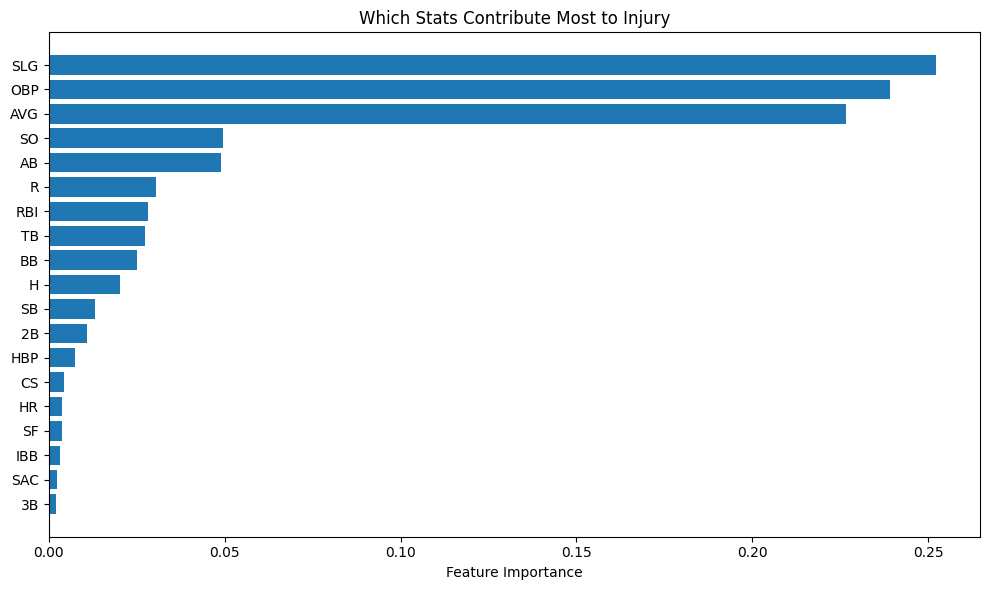

In [121]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt


# STEP 1: Load your labeled dataset
df = game_logs.copy()

# STEP 2: Drop irrelevant columns
irrelevant_cols = ["Name", "Date", "Team", "OPP", "mlb_player_id"]
df = df.drop(columns=[col for col in irrelevant_cols if col in df.columns])

# STEP 3: Drop rows with missing values
df = df.dropna()

# STEP 4: Define features (X) and target (y)
X = df.drop(columns=["Injured", "PlayerID"])
y = df["Injured"]

# STEP 5: Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# STEP 6: Train a model (Random Forest works well for feature importance)
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# STEP 7: Evaluate the model
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

# STEP 8: Plot feature importances
importances = model.feature_importances_
features = X.columns
sorted_idx = importances.argsort()[::-1]

plt.figure(figsize=(10, 6))
plt.barh(features[sorted_idx], importances[sorted_idx])
plt.xlabel("Feature Importance")
plt.title("Which Stats Contribute Most to Injury")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [128]:
%pip install imbalanced-learn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE 

  Using cached imbalanced_learn-0.13.0-py3-none-any.whl.metadata (8.8 kB)
  Using cached sklearn_compat-0.1.3-py3-none-any.whl.metadata (18 kB)
Using cached imbalanced_learn-0.13.0-py3-none-any.whl (238 kB)
Using cached sklearn_compat-0.1.3-py3-none-any.whl (18 kB)

[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [130]:
from imblearn.over_sampling import SMOTE 

# STEP 1: Load dataset
df = game_logs.copy()
df["Date"] = pd.to_datetime(df["Date"])

# STEP 2: Drop non-numeric or identifier columns
df = df.drop(columns=["Name", "Date", "Team", "OPP"])  # Keep PlayerID for rolling logic

# STEP 3: Calculate 5-game rolling averages per player
df = df.sort_values(["PlayerID"])
stats_cols = df.drop(columns=["PlayerID", "Injured"]).columns

# Add rolling stats
for col in stats_cols:
    df[f"{col}_roll5"] = df.groupby("PlayerID")[col].transform(lambda x: x.rolling(5, min_periods=1).mean())

# STEP 4: Drop original stat columns and PlayerID
df = df.drop(columns=list(stats_cols) + ["PlayerID"])

# STEP 5: Drop missing values
df = df.dropna()

# STEP 6: Split features and labels
X = df.drop(columns=["Injured"])
y = df["Injured"]

# STEP 7: Train/Test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# STEP 8: Handle class imbalance with SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# STEP 9: Scale features (for LR)
scaler = StandardScaler()
X_resampled_scaled = scaler.fit_transform(X_resampled)
X_test_scaled = scaler.transform(X_test)

# STEP 10: Train models
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_resampled, y_resampled)
y_pred_rf = rf.predict(X_test)

lr = LogisticRegression(max_iter=1000)
lr.fit(X_resampled_scaled, y_resampled)
y_pred_lr = lr.predict(X_test_scaled)



In [133]:
# STEP 11: Evaluation
print("=== Random Forest Classification Report ===")
print(classification_report(y_test, y_pred_rf))

print("\n=== Logistic Regression Classification Report ===")
print(classification_report(y_test, y_pred_lr))

=== Random Forest Classification Report ===
              precision    recall  f1-score   support

           0       0.91      0.99      0.95     39588
           1       0.72      0.12      0.21      4286

    accuracy                           0.91     43874
   macro avg       0.82      0.56      0.58     43874
weighted avg       0.89      0.91      0.88     43874


=== Logistic Regression Classification Report ===
              precision    recall  f1-score   support

           0       0.91      0.45      0.60     39588
           1       0.10      0.58      0.17      4286

    accuracy                           0.46     43874
   macro avg       0.51      0.52      0.39     43874
weighted avg       0.83      0.46      0.56     43874



In [ ]:
# STEP 12: Plot Feature Importances (Random Forest)
importances = rf.feature_importances_
features = X.columns
sorted_idx = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 6))
plt.barh(features[sorted_idx], importances[sorted_idx])
plt.xlabel("Feature Importance")
plt.title("Which Stats Contribute Most to Injury (5-Game Rolling Avg.)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# STEP 13: Plot Correlation Heatmap
plt.figure(figsize=(12, 10))
corr = df.corr()
sns.heatmap(corr[["Injured"]].sort_values(by="Injured", ascending=False), annot=True, cmap="coolwarm", linewidths=0.5)
plt.title("Correlation of Features with Injury")
plt.tight_layout()
plt.show()

In [139]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier, plot_importance

In [ ]:
# STEP 1: Load your prepared game logs DataFrame
df = game_logs_df.copy()
df["Date"] = pd.to_datetime(df["Date"])

# STEP 2: Drop non-feature columns
df = df.drop(columns=["Name", "Date", "Team", "OPP"])  # keep PlayerID for grouping

# STEP 3: Compute 5-game rolling averages per player
df = df.sort_values(["PlayerID"])
stats_cols = df.drop(columns=["PlayerID", "Injured"]).columns

for col in stats_cols:
    df[f"{col}_roll5"] = df.groupby("PlayerID")[col].transform(lambda x: x.rolling(5, min_periods=1).mean())

# STEP 4: Drop original stats and PlayerID
df = df.drop(columns=list(stats_cols) + ["PlayerID"])

# STEP 5: Drop any remaining NaNs
df = df.dropna()

# STEP 6: Split features and labels
X = df.drop(columns=["Injured"])
y = df["Injured"]

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# STEP 7: Balance the training set using SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# STEP 8: Train XGBoost (no scale_pos_weight since we used SMOTE)
xgb_model = XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    use_label_encoder=False,
    eval_metric='logloss'
)

xgb_model.fit(X_resampled, y_resampled)

# STEP 9: Predict with custom threshold (0.3)
y_probs = xgb_model.predict_proba(X_test)[:, 1]
y_pred = (y_probs > 0.3).astype(int)

# STEP 10: Evaluate model
print("=== XGBoost Classification Report (threshold = 0.3) ===")
print(classification_report(y_test, y_pred))

/Users/daniellarson/Desktop/Code/Projects/dodgers_injtrkr/venv/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [16:47:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


=== XGBoost Classification Report ===
              precision    recall  f1-score   support

           0       0.90      1.00      0.95     39649
           1       0.10      0.00      0.01      4225

    accuracy                           0.90     43874
   macro avg       0.50      0.50      0.48     43874
weighted avg       0.83      0.90      0.86     43874



In [ ]:
# STEP 10: Plot Feature Importances
plt.figure(figsize=(10, 6))
plot_importance(xgb_model, max_num_features=15, height=0.5, importance_type='gain')
plt.title("Top Stats Contributing to Injury (XGBoost)")
plt.tight_layout()
plt.show()

# STEP 11: Correlation Heatmap
plt.figure(figsize=(12, 10))
corr = df.corr()
sns.heatmap(corr[["Injured"]].sort_values(by="Injured", ascending=False), annot=True, cmap="coolwarm", linewidths=0.5)
plt.title("Correlation of Features with Injury")
plt.tight_layout()
plt.show()

## Stats

In [22]:
query = """
SELECT mlb_player_stats.*, mlb_player_info.*, injury_stats.*
FROM mlb_player_stats
JOIN mlb_player_info ON mlb_player_stats.mlb_player_id = mlb_player_info.mlb_player_id
JOIN injury_stats ON mlb_player_stats.mlb_player_id = injury_stats.mlb_player_id
WHERE mlb_player_stats.team_name = 'Los Angeles Dodgers'
  AND mlb_player_stats.season = 2020
;
"""

dodgers_injury_2025 = pd.read_sql_query(query, conn)

dodgers_injury_2025



,mlb_player_id,stat_type,stat_group,season,game_date,team_id,team_name,opponent_id,opponent_name,position,gamesPlayed,games,gamesStarted,assists,putOuts,errors,chances,fielding,doublePlays,triplePlays,throwingErrors,rangeFactorPerGame,rangeFactorPer9Inn,innings,inningsPitched,catcherERA,flyOuts,groundOuts,airOuts,passedBall,wins,losses,wildPitches,pickoffs,runs,doubles,triples,homeRuns,strikeOuts,baseOnBalls,intentionalWalks,hits,hitByPitch,avg,atBats,obp,slg,ops,caughtStealing,stolenBases,stolenBasePercentage,groundIntoDoublePlay,groundIntoTriplePlay,numberOfPitches,plateAppearances,totalBases,rbi,leftOnBase,sacBunts,sacFlies,babip,groundOutsToAirouts,catchersInterference,atBatsPerHomeRun,summary,isHome,isWin,game_id,game_number,day_night,era,game,id,mlb_player_id,fullName,firstName,lastName,birthDate,currentAge,birthCity,birthStateProvince,birthCountry,height,weight,primaryPosition,batSide,pitchHand,debutDate,active,mlb_player_id,player_name,injury_date,season,injury_description,team_name
0,457759,season,fielding,2020,None,119,Los Angeles Dodgers,NaN,None,NA,32,32,32.0,63.0,17.0,4.0,84.0,.952,7.0,0.0,3.0,2.50,2.74,263.2,None,None,NaN,NaN,NaN,NaN,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,None,None,None,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None,NaN,None,None,NaN,NaN,NaN,NaN,None,na,na,996,457759,Justin Turner,Justin,Turner,1984-11-23,40,Long Beach,CA,USA,"5' 11""",208,First Base,Right,Right,2009-09-08,1,457759,Justin Turner,2009-06-11,2009,Norfolk Tides placed 2B Justin Turner on the 7...,Norfolk Tides
1,457759,season,fielding,2020,None,119,Los Angeles Dodgers,NaN,None,NA,32,32,32.0,63.0,17.0,4.0,84.0,.952,7.0,0.0,3.0,2.50,2.74,263.2,None,None,NaN,NaN,NaN,NaN,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,None,None,None,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None,NaN,None,None,NaN,NaN,NaN,NaN,None,na,na,996,457759,Justin Turner,Justin,Turner,1984-11-23,40,Long Beach,CA,USA,"5' 11""",208,First Base,Right,Right,2009-09-08,1,457759,Justin Turner,2012-05-29,2012,New York Mets placed 2B Justin Turner on the 1...,New York Mets
2,457759,season,fielding,2020,None,119,Los Angeles Dodgers,NaN,None,NA,32,32,32.0,63.0,17.0,4.0,84.0,.952,7.0,0.0,3.0,2.50,2.74,263.2,None,None,NaN,NaN,NaN,NaN,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,None,None,None,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None,NaN,None,None,NaN,NaN,NaN,NaN,None,na,na,996,457759,Justin Turner,Justin,Turner,1984-11-23,40,Long Beach,CA,USA,"5' 11""",208,First Base,Right,Right,2009-09-08,1,457759,Justin Turner,2012-06-16,2012,New York Mets activated 1B Justin Turner from ...,New York Mets
3,457759,season,fielding,2020,None,119,Los Angeles Dodgers,NaN,None,NA,32,32,32.0,63.0,17.0,4.0,84.0,.952,7.0,0.0,3.0,2.50,2.74,263.2,None,None,NaN,NaN,NaN,NaN,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,None,None,None,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None,NaN,None,None,NaN,NaN,NaN,NaN,None,na,na,996,457759,Justin Turner,Justin,Turner,1984-11-23,40,Long Beach,CA,USA,"5' 11""",208,First Base,Right,Right,2009-09-08,1,457759,Justin Turner,2013-06-18,2013,New York Mets placed 1B Justin Turner on the 1...,New York Mets
4,457759,season,fielding,2020,None,119,Los Angeles Dodgers,NaN,None,NA,32,32,32.0,63.0,17.0,4.0,84.0,.952,7.0,0.0,3.0,2.50,2.74,263.2,None,None,NaN,NaN,NaN,NaN,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,None,None,None,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None,NaN,None,None,NaN,NaN,NaN,NaN,None,na,na,996,457759,Justin Turner,Justin,Turner,1984-11-23,40,Long Beach,CA,USA,"5' 11""",208,First Base,Right,Right,2009-09-08,1,457759,Justin Turner,2013-07-22,2013,New York Mets activated 3B Justin Turner from ...,New York Mets
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,..

In [92]:
# The Top 10 players with the most injuries

query = """
SELECT 
    player_name,
    COUNT(*) AS injury_count
FROM 
    injury_stats
GROUP BY 
    player_name
ORDER BY 
    injury_count DESC
LIMIT 10;
"""

pd.read_sql_query(query, conn)

,player_name,injury_count
0,Byron Buxton,37
1,Jason Heyward,35
2,Zach Eflin,31
3,Tyler O'Neill,31
4,Steven Matz,30
5,Jorge Soler,29
6,Max Fried,28
7,Lance McCullers Jr.,28
8,Mike Clevinger,27
9,Kyle Higashioka,27
